D:\bai_work_win\AngioMorph\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
D:\bai_work_win\AngioMorph\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


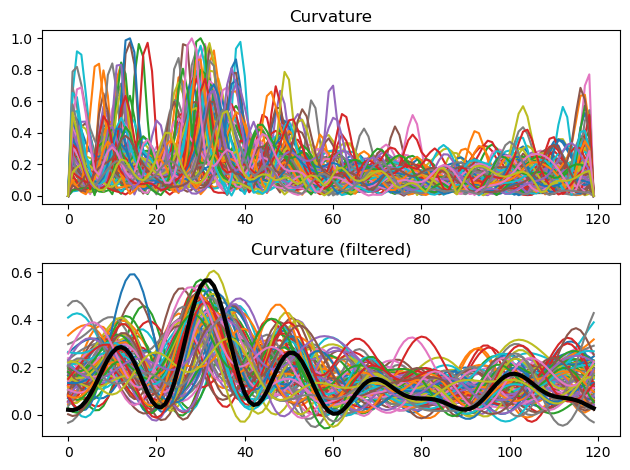

  9%|▉         | 7/78 [00:13<02:16,  1.92s/it]

In [2]:
import sys
sys.path.append('D:\\bai_work_win\\AngioMorph\\src')

import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile, mkdir
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)


def compute_centroid(curves):
    centroid = np.mean(curves, axis=0)
    return np.array(centroid)
def translate_to_centroid(curves):
    centroid = compute_centroid(curves)
    new_curves = []
    for i in range(len(curves)):
        new_curves.append(curves[i] - centroid)
    return np.array(new_curves)



def plot_curve(curve, ax=None, add_origin=True):
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        curve = insert_zeros(curve, axis=-2)

    ax.plot(*[curve[:, k] for k in range(3)])
    ax.scatter(*[curve[0, k] for k in range(3)])
    return ax


def plot_geodesic(geod_points, ax=None, add_origin=True):
    n_times = geod_points.shape[0]
    k_sampling_points = geod_points.shape[-2] + 1

    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection="3d")

    if add_origin:
        geod_points = insert_zeros(geod_points, axis=-2)

    ax.plot(*[geod_points[0, :, k] for k in range(3)],  c="b", linewidth=2)
    ax.plot(*[geod_points[-1, :, k] for k in range(3)], c="r", linewidth=2)

    for i in range(1, n_times - 1):
        ax.plot(*[geod_points[i, :, k] for k in range(3)], c="k", linewidth=1)

    for j in range(k_sampling_points - 1):
        ax.plot(*[geod_points[:, j, k] for k in range(3)], c="k", linewidth=1)

    return ax



brava_files = glob.glob('brava_ica_mirrored/*.vtk')
aneurisk_files = []
# aneurisk_files = glob.glob('aneurisk_ica_mirrored/*.vtk')
total_files = brava_files + aneurisk_files
np.save("total_files.npy", total_files)

resample_num=120


curvatures=[]
curves = []
freq_threshold = 0.06
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# ax3 = fig.add_subplot(313)
for i in range(len(total_files)):
    casename = total_files[i].split('\\')[-1].split('.')[0]
    temp = Get_simple_vtk(total_files[i])
    temp = translate_to_centroid(temp)
    temp_func = parameterize_curve(temp) # 重参数化，归一化，成了单位长度
    t_resampled = np.linspace(0, 1, resample_num) # 重采样，生成一个从 0 到 1 的均匀分布
    resampled_curve = temp_func(t_resampled) # 用重采样的 t 值生成新的曲线
    curves.append(resampled_curve)
    c, t = compute_curvature_and_torsion(resampled_curve)
    ax1.plot(c, label=casename)
    fft_c = remove_high_freq_components(c, freq_threshold ) # 傅里叶变换去高频
    rebuild = build_curve_from_curvatures(fft_c, step_length=0.1)
    ax2.plot(fft_c, label=casename)
    ax1.set_title('Curvature')
    ax2.set_title('Curvature (filtered)')
    # ax3.plot(rebuild[0], rebuild[1], label=casename)
    # print (len(c), len(fft_c))
    curvatures.append(fft_c)
curvatures = np.array(curvatures)

np.save("unaligned_curvatures.npy", curvatures)
mean_curve = np.mean(curves, axis=0)
mean_curve_curvature, _ = compute_curvature_and_torsion(mean_curve)
mean_curve_curvature = remove_high_freq_components(mean_curve_curvature, freq_threshold)
ax2.plot(mean_curve_curvature, label='Mean',linewidth=3, color='black')
plt.tight_layout()
plt.show()


k_sampling_points = resample_num

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=False
) # geomstats库中的类,初始化曲线空间

curves_r3.equip_with_metric(SRVMetric) # geomstats库中的类,配置SRV度量
curve_a = curves_r3.projection(curves[0])
curve_a = curves_r3.normalize(curve_a) # 缩放为单位长度
curve_bs = []
curve_bs.append(curve_a)
fig= plt.figure(dpi=200)
ax1 = fig.add_subplot(111,projection='3d')
# ax2 = fig.add_subplot(122,projection='3d')
plot_curve(curve_a, ax=ax1)
for i in tqdm(range(1,len(curves))):
# for i in range(4):
    curve_b = curves_r3.projection(curves[i])
    curve_b = curves_r3.normalize(curve_b)

    curves_r3.equip_with_group_action("rotations and reparametrizations")
    curves_r3.equip_with_quotient_structure()


    curve_b_aligned = curves_r3.fiber_bundle.align(curve_b, curve_a)
    curve_bs.append(np.array(curve_b))

    # hgeod_fun = curves_r3.quotient.metric.geodesic(curve_a, curve_b)

    # n_times = 10
    # times = gs.linspace(0.0, 1.0, n_times)
    # hgeod = hgeod_fun(times)

    plot_curve(curve_b_aligned, ax=ax1)
curve_bs = np.array(curve_bs)
ax1.set_title("Aligned curves")
# plot_geodesic(hgeod, ax=ax2)
# ax2.set_title("Horizontal geodesic")
plt.show()




mean = FrechetMean(curves_r3)
mean.fit(curve_bs)

mean_estimate = mean.estimate_


